<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep7-eda-modeling?scriptVersionId=119195390" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#Notebook-Versions)

[2. Loading Libraries](#Loading-Libraries)

[3. Reading Data Files](#Reading-Data-Files)

[4. Data Description](#Data-Description)

[5. Data Exploration](#Data-Exploration)

[6. LightGBM Modeling](#LightGBM-Modeling)

[7. LightGBM Modeling Optuna](#LightGBM-Modeling-Optuna)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (02/13/2023)
    * EDA 
    * LightGBM Modeling
    
2. Version 2 (02/14/2023)
    * Data description added
    * LightGBM optuna hyper-parameters
    
<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e7/train.csv')
test = pd.read_csv('../input/playground-series-s3e7/test.csv')
submission = pd.read_csv('../input/playground-series-s3e7/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (42100, 19)
The dimession of the test dataset is: (28068, 18)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28068 entries, 0 to 28067
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    28068 non-null  int64  
 1   no_of_adults                          28068 non-null  int64  
 2   no_of_children                        28068 non-null  int64  
 3   no_of_weekend_nights                  28068 non-null  int64  
 4   no_of_week_nights                     28068 non-null  int64  
 5   type_of_meal_plan                     28068 non-null  int64  
 6   required_car_parking_space            28068 non-null  int64  
 7   room_type_reserved                    28068 non-null  int64  
 8   lead_time                             28068 non-null  int64  
 9   arrival_year                          28068 non-null  int64  
 10  arrival_month                         28068 non-null  int64  
 11  arrival_date   

In [5]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [6]:
train.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,21049.500000,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,12153.367503,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10524.750000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,21049.500000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,31574.250000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,42099.000000,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [7]:
test.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0


In [8]:
test.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,28068.000000,28068.000000,28068.000000,28068.00000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000
mean,56133.500000,1.915313,0.140872,0.88877,2.387559,0.234110,0.027006,0.430668,103.845554,2017.856705,7.583903,15.867643,0.725951,0.030711,0.024975,0.196736,104.644460,0.573643
std,8102.678014,0.526279,0.447277,0.87825,1.403213,0.581256,0.162103,0.830187,81.134833,0.350380,2.831911,8.934570,0.629044,0.172537,0.410583,1.941456,36.818948,0.769765
min,42100.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49116.750000,2.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000
50%,56133.500000,2.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,92.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,63150.250000,2.000000,0.000000,2.00000,3.000000,0.000000,0.000000,1.000000,154.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000
max,70167.000000,4.000000,9.000000,6.00000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Reservation Cancellation Prediction](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction) dataset. These are the descriptions of the variables in this dataset:

<ul>
    <li> id: unique identifier of each booking. </li>
    <li> no_of_adults: number of adults. </li>
    <li> no_of_children: number of Children. </li>
    <li> no_of_weekend_nights: number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel. </li>
    <li> no_of_week_nights: number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel.  </li>
    <li> type_of_meal_plan: type of meal plan booked by the customer. </li>
    <li> required_car_parking_space: does the customer require a car parking space? (0 - No, 1- Yes). </li>
    <li> room_type_reserved: type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.. </li>
    <li> lead_time: number of days between the date of booking and the arrival date. </li>
    <li> arrival_year: year of arrival date. </li>
    <li> arrival_month: month of arrival date. </li>
    <li> arrival_date: date of the month. </li>
    <li> market_segment_type: market segment designation. </li>
    <li> repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes). </li>
    <li> no_of_previous_cancellations: number of previous bookings that were canceled by the customer prior to the current booking. </li>
    <li> no_of_previous_bookings_not_canceled: number of previous bookings not canceled by the customer prior to the current booking. </li>
    <li> avg_price_per_room: average price per day of the reservation; prices of the rooms are dynamic. (in euros). </li>
    <li> no_of_special_requests: total number of special requests made by the customer (e.g. high floor, view from the room, etc). </li>
    <li> booking_status: flag indicating if the booking was canceled or not. </li>
</ul>


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

In [9]:
round(100*train['booking_status'].value_counts() / train.shape[0], 2) 

0    60.8
1    39.2
Name: booking_status, dtype: float64

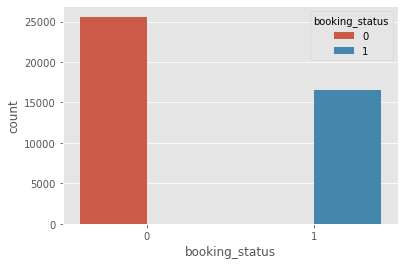

In [10]:
sns.countplot(x = 'booking_status', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that the data is not that imbalanced (close to be 50-50).</div>

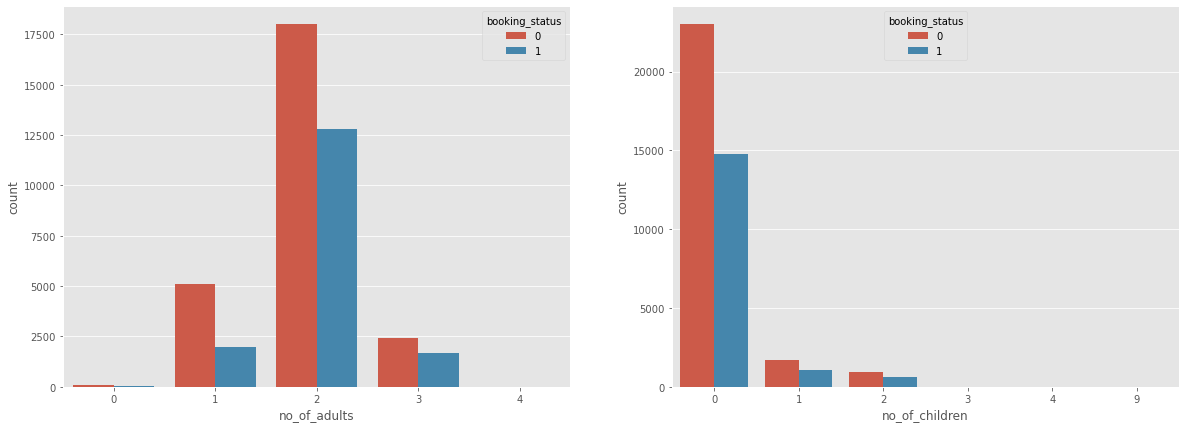

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))

sns.countplot(ax = axes[0], x = 'no_of_adults', hue = 'booking_status', data = train);
sns.countplot(ax = axes[1], x = 'no_of_children', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, we see that there a couple of reservations with 0 adults, which is suspicious.</div>

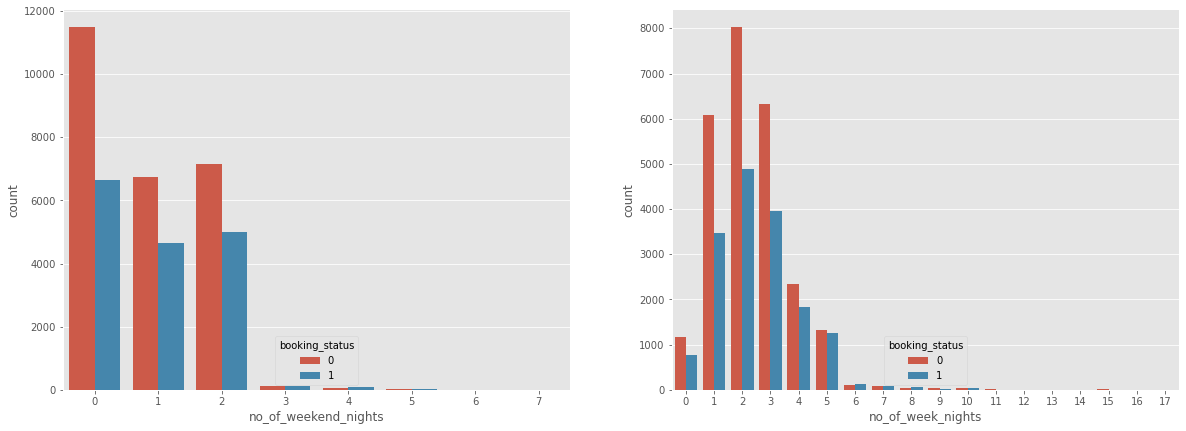

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))

sns.countplot(ax = axes[0], x = 'no_of_weekend_nights', hue = 'booking_status', data = train);
sns.countplot(ax = axes[1], x = 'no_of_week_nights', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, we see that there are a few reservations with three or more weekend nights, which is not possible. From the above the right panel, we see that there are a few reservations with 6 of more week nights. </div>

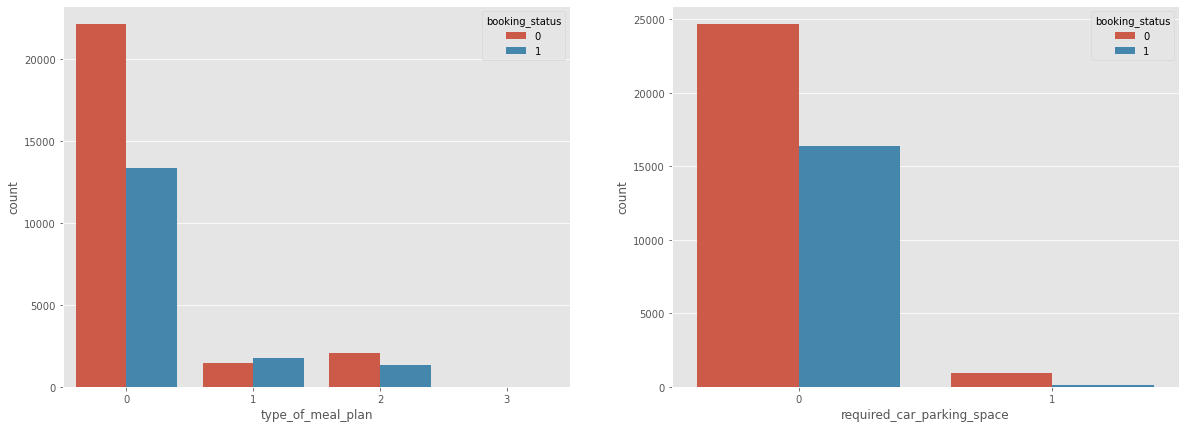

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))

sns.countplot(ax = axes[0], x = 'type_of_meal_plan', hue = 'booking_status', data = train);
sns.countplot(ax = axes[1], x = 'required_car_parking_space', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, we see that the number of cancellations is higher when the type of meal plan is 1. </div>

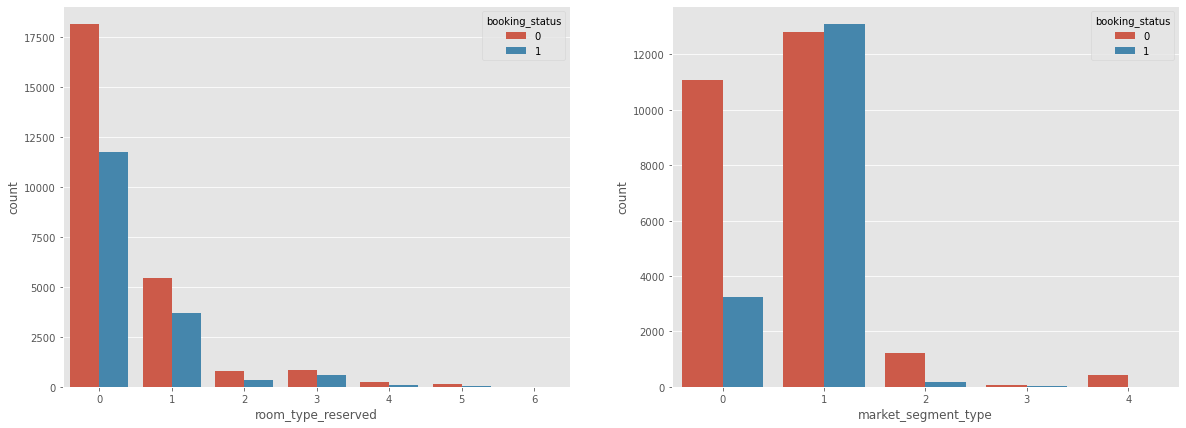

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))

sns.countplot(ax = axes[0], x = 'room_type_reserved', hue = 'booking_status', data = train);
sns.countplot(ax = axes[1], x = 'market_segment_type', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above right panel, customers from market segment type 1 are more likely to cancel their reservations. </div>

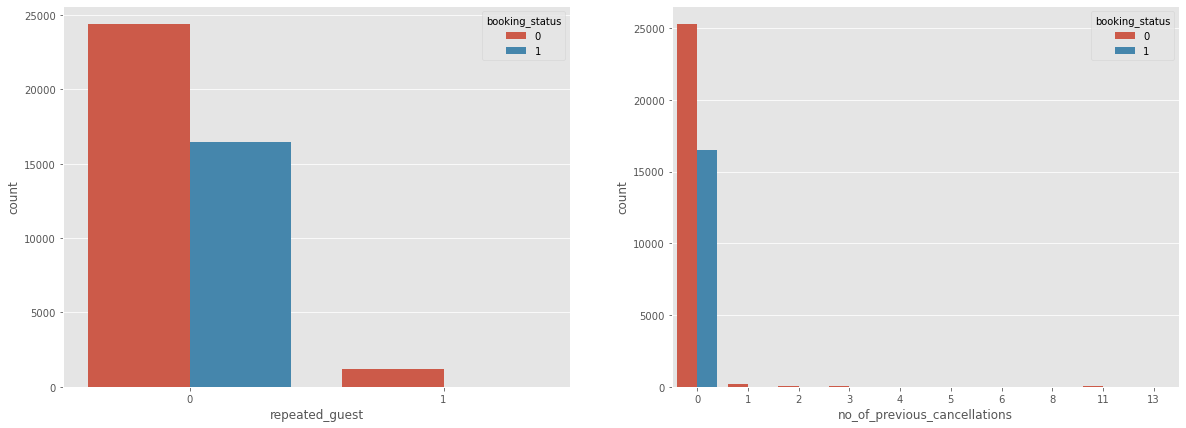

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))

sns.countplot(ax = axes[0], x = 'repeated_guest', hue = 'booking_status', data = train);
sns.countplot(ax = axes[1], x = 'no_of_previous_cancellations', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, repeated guests didn't cancel their reservations. </div>

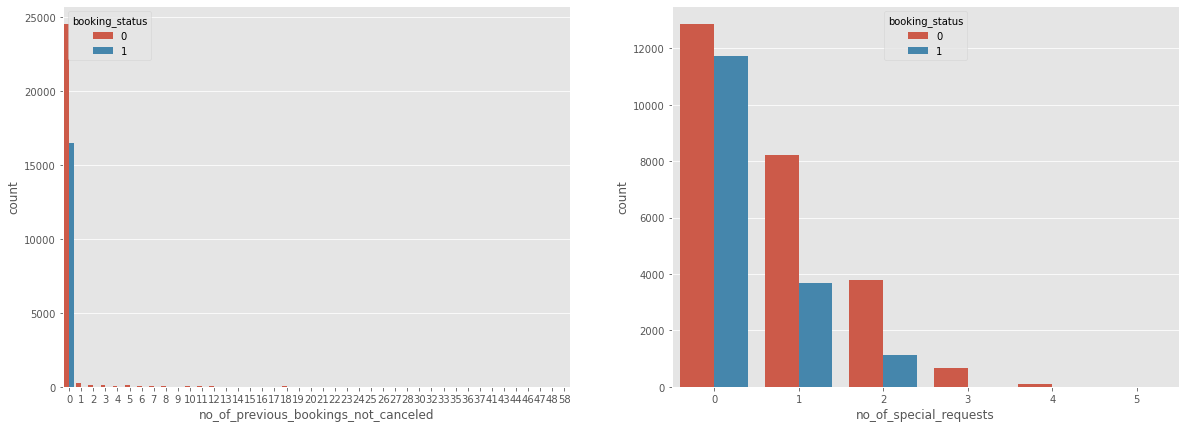

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))

sns.countplot(ax = axes[0], x = 'no_of_previous_bookings_not_canceled', hue = 'booking_status', data = train);
sns.countplot(ax = axes[1], x = 'no_of_special_requests', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, we see that customers, who didn't cancel one or more of their previous booking, didn't cancel theur reservations. </div>

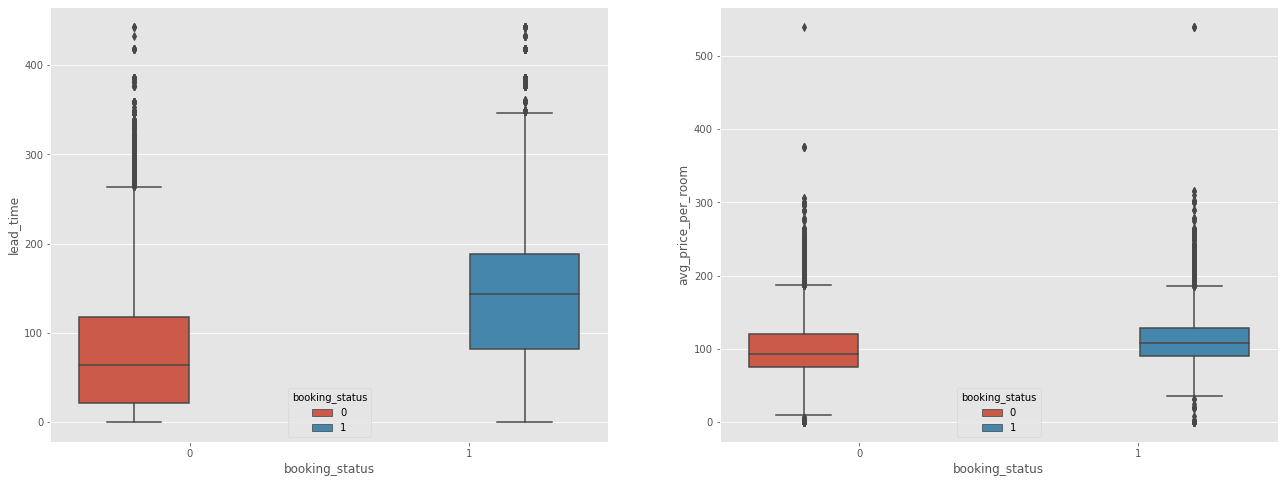

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'booking_status', y = 'lead_time', hue = 'booking_status', data = train)
sns.boxplot(ax = axes[1], x = 'booking_status', y = 'avg_price_per_room', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, we see that, on average, as the number of days between the date of booking and the arrival date increases, the reservation is more likely to be cancelled. From the above right panel, there is a slighlty difference when comparing the average price room between reservations that were cancelled and reservations that were not cancelled. </div>

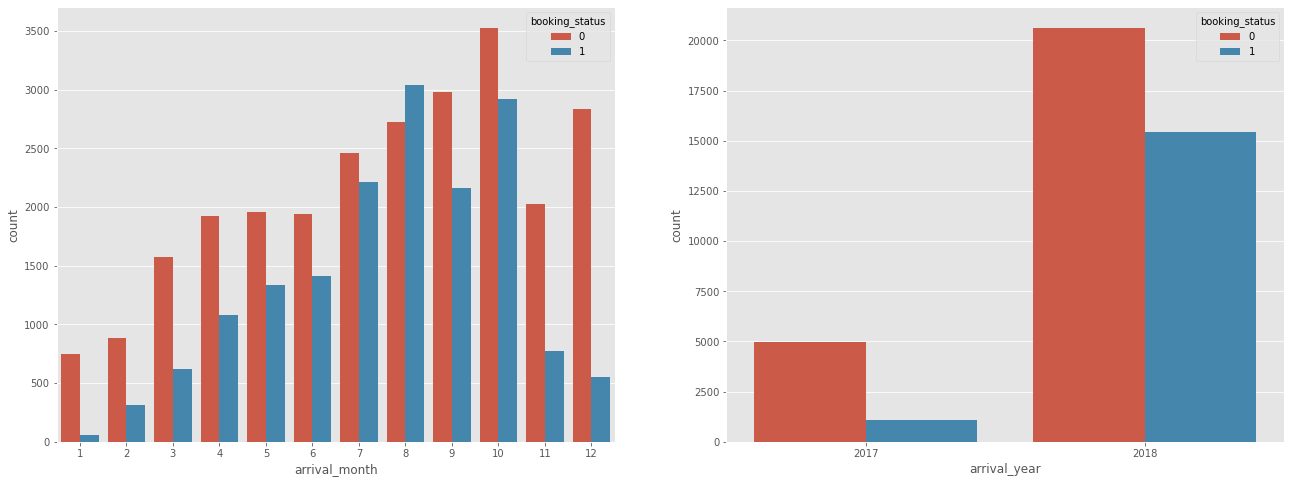

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.countplot(ax = axes[0], x = 'arrival_month', hue = 'booking_status', data = train)
sns.countplot(ax = axes[1], x = 'arrival_year', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above left panel, we see that in August reservations are more likely to be cancelled than any other month. </div>

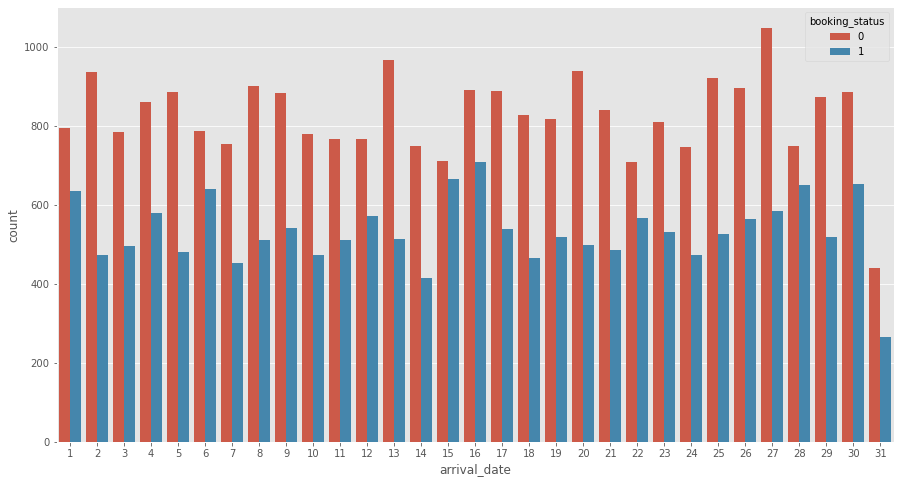

In [19]:
plt.figure(figsize = (15, 8))

sns.countplot(x = 'arrival_date', hue = 'booking_status', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that in the midle of the month reservations are more likeliy to be cancelled. </div>

<div class="alert alert-block alert-info">
<b>💡 Insights from EDA:</b><br> 
<ul>
    <li> The dataset is not that imbalanced (~60%-~40%). </li>
    <li> There a couple of reservations with 0 adults, which is supicious. </li>
    <li> There are a few reservations with three or more weekend nights. </li>
    <li> There are a few reservations with 6 of more week nights. </li>
    <li> Customers from market segment type 1 are more likely to cancel their reservations.  </li>
    <li> Repeated guests didn't cancel their reservations. </li>
    <li> On average, as the number of days between the date of booking and the arrival date increases, the reservation is more likely to be cancelled. </li>
    <li> August reservations are more likely to be cancelled than any other month. </li>
    <li> Reservations in the middle of the month are more likely to be cancelled. </li>
</ul>
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">LightGBM Modeling</h1> 

In [20]:
train_lgb = train.copy()
test_lgb = test.copy()

X = train_lgb.drop(columns = ['id', 'booking_status'], axis = 1)
Y = train_lgb['booking_status']

test_lgb = test_lgb.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 20,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

In [21]:
## Building model in the entire train dataset
lgb_md = LGBMClassifier(n_estimators = 1000,
                        max_depth = 7,
                        learning_rate = 0.01,
                        num_leaves = 20,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7).fit(X, Y)

train_preds = pd.DataFrame({'booking_status': Y, 'booking_status_pred': lgb_md.predict_proba(X)[:, 1]})
train_preds.head()

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,booking_status,booking_status_pred
0,0,0.033249
1,0,0.230438
2,0,0.235461
3,0,0.145576
4,1,0.878751


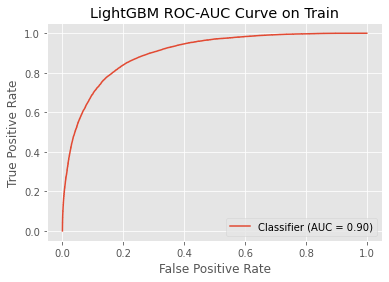

In [22]:
RocCurveDisplay.from_predictions(train_preds['booking_status'], train_preds['booking_status_pred'])
plt.title('LightGBM ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

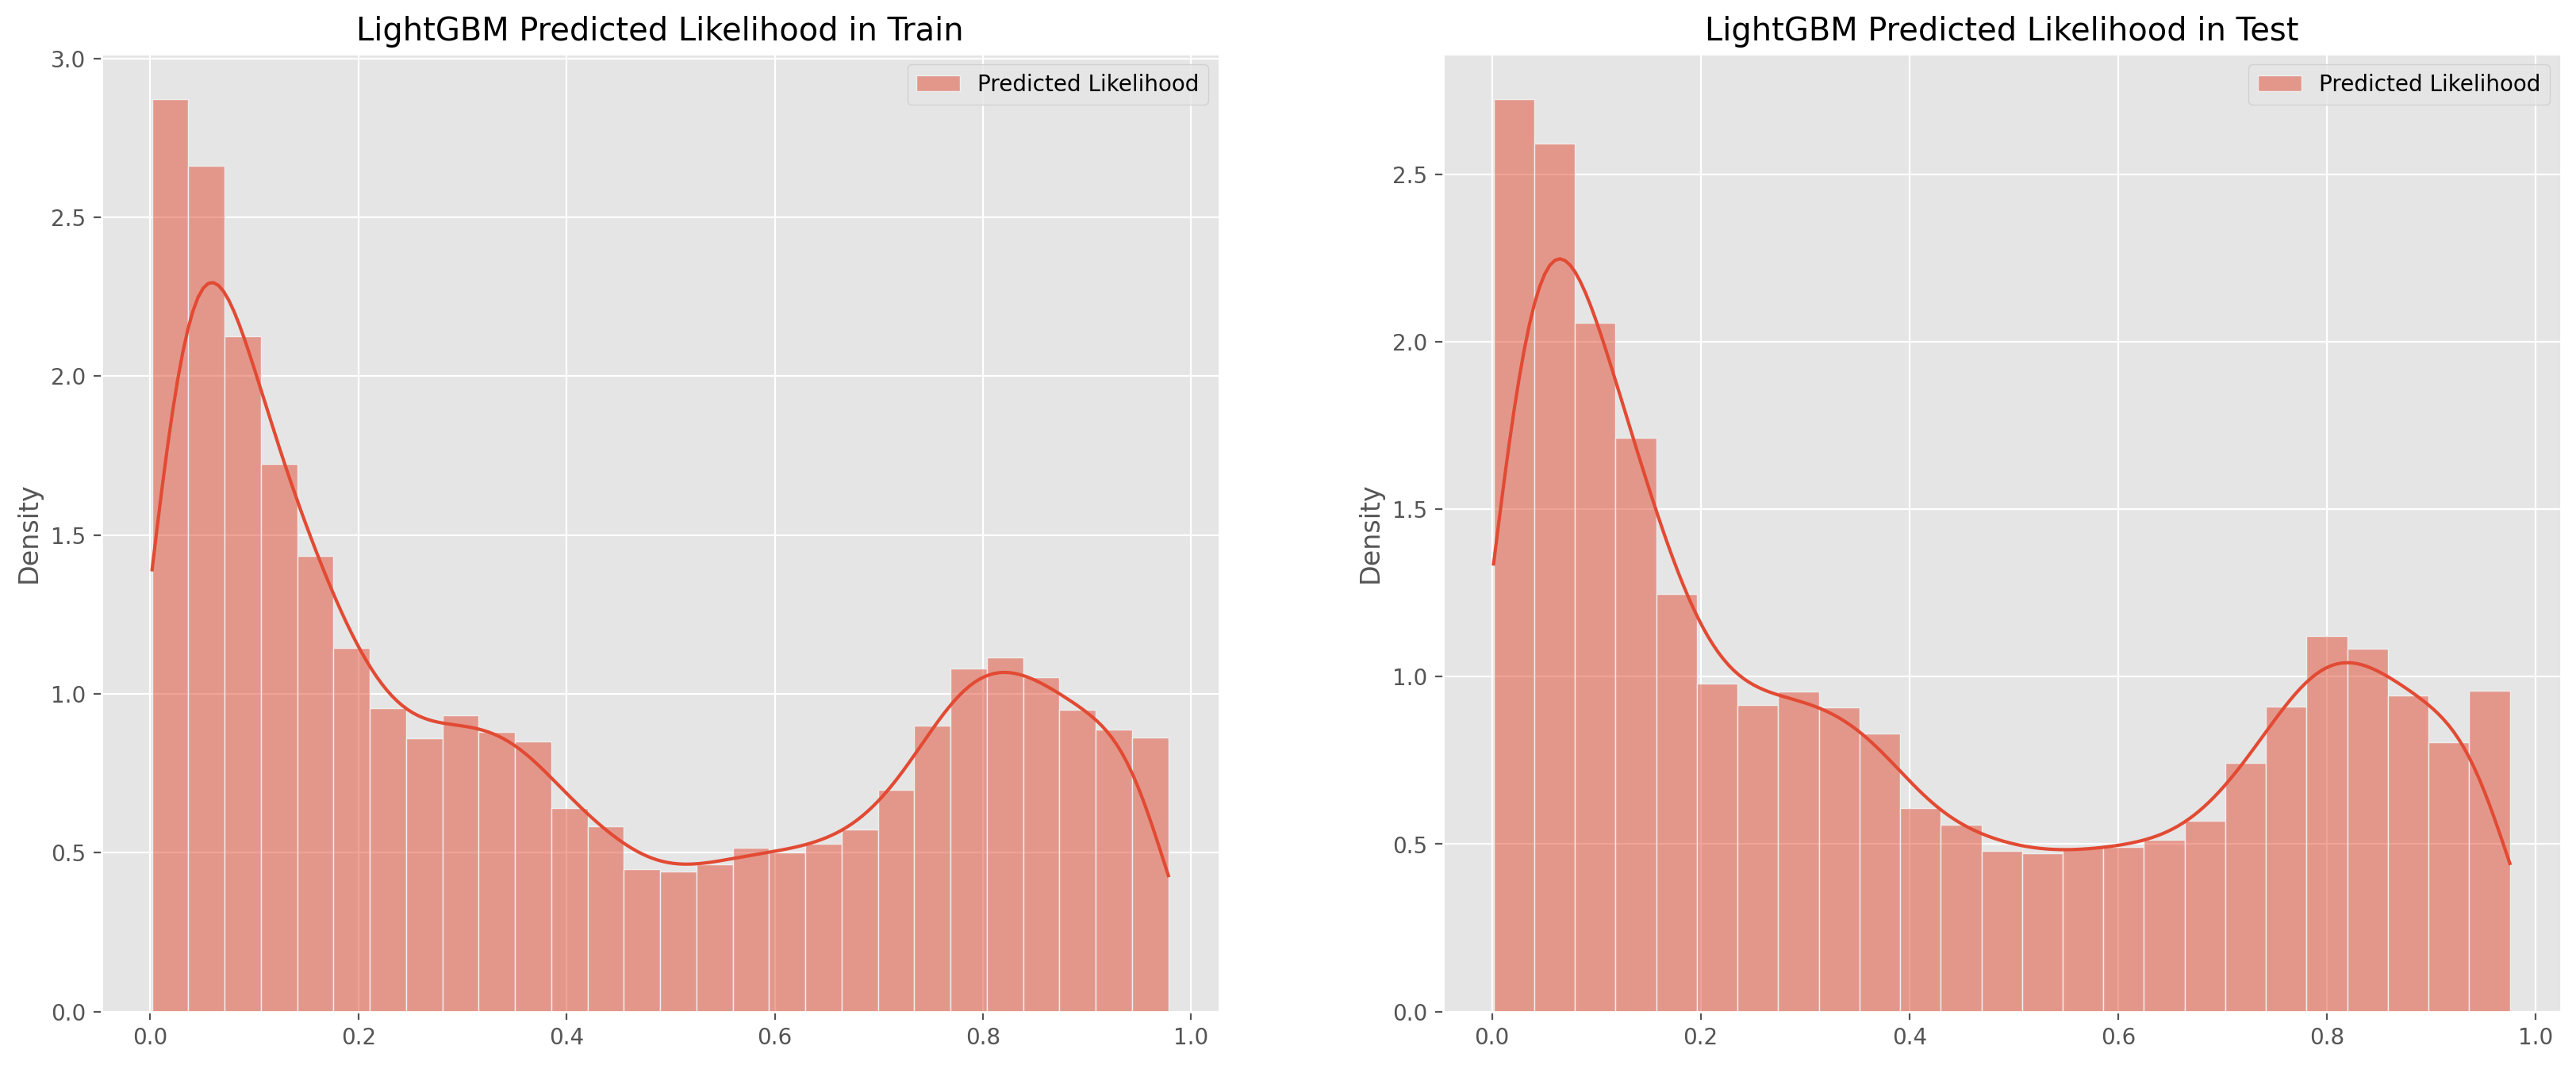

In [23]:
lgb_preds_train = train_preds['booking_status_pred']
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': lgb_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': lgb_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'LightGBM Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'LightGBM Predicted Likelihood in Test')
plt.show();

In [24]:
submission['booking_status'] = lgb_preds_test
submission.head()

,id,booking_status
0,42100,0.125024
1,42101,0.064670
2,42102,0.391655
3,42103,0.089286
4,42104,0.616536


In [25]:
submission.to_csv('Baseline_LightGBM_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">LightGBM Modeling Optuna</h1>

In this section, we re-run the LightGBM model using optimal hyper-parameters from the optuna framework.

In [26]:
train_lgb = train.copy()
test_lgb = test.copy()

X = train_lgb.drop(columns = ['id', 'booking_status'], axis = 1)
Y = train_lgb['booking_status']

test_lgb = test_lgb.drop(columns = ['id'], axis = 1)

In [27]:
cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 7880,
                                max_depth = 10,
                                learning_rate = 0.009689077948120357,
                                num_leaves = 20,
                                lambda_l1 = 1.2185030034603348,
                                lambda_l2 = 1.8144608820124146,
                                bagging_fraction = 0.6383698341881532,
                                feature_fraction = 0.5452440168291733).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=1.2185030034603348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2185030034603348
[LightGBM] [Warning] feature_fraction is set=0.5452440168291733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5452440168291733
[LightGBM] [Warning] lambda_l2 is set=1.8144608820124146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8144608820124146
[LightGBM] [Warning] bagging_fraction is set=0.6383698341881532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6383698341881532
[LightGBM] [Warning] lambda_l1 is set=1.2185030034603348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2185030034603348
[LightGBM] [Warning] feature_fraction is set=0.5452440168291733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5452440168291733
[LightGBM] [Warning] lambda_l2 is set=1.8144608820124146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8144608820124146
[LightGBM] 

In [28]:
## Building model in the entire train dataset
lgb_md = LGBMClassifier(n_estimators = 7880,
                        max_depth = 10,
                        learning_rate = 0.009689077948120357,
                        num_leaves = 20,
                        lambda_l1 = 1.2185030034603348,
                        lambda_l2 = 1.8144608820124146,
                        bagging_fraction = 0.6383698341881532,
                        feature_fraction = 0.5452440168291733).fit(X, Y)

train_preds = pd.DataFrame({'booking_status': Y, 'booking_status_pred': lgb_md.predict_proba(X)[:, 1]})
train_preds.head()

[LightGBM] [Warning] lambda_l1 is set=1.2185030034603348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2185030034603348
[LightGBM] [Warning] feature_fraction is set=0.5452440168291733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5452440168291733
[LightGBM] [Warning] lambda_l2 is set=1.8144608820124146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8144608820124146
[LightGBM] [Warning] bagging_fraction is set=0.6383698341881532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6383698341881532


,booking_status,booking_status_pred
0,0,0.020305
1,0,0.130175
2,0,0.141893
3,0,0.124123
4,1,0.941562


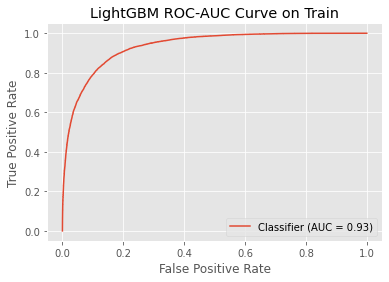

In [29]:
RocCurveDisplay.from_predictions(train_preds['booking_status'], train_preds['booking_status_pred'])
plt.title('LightGBM ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

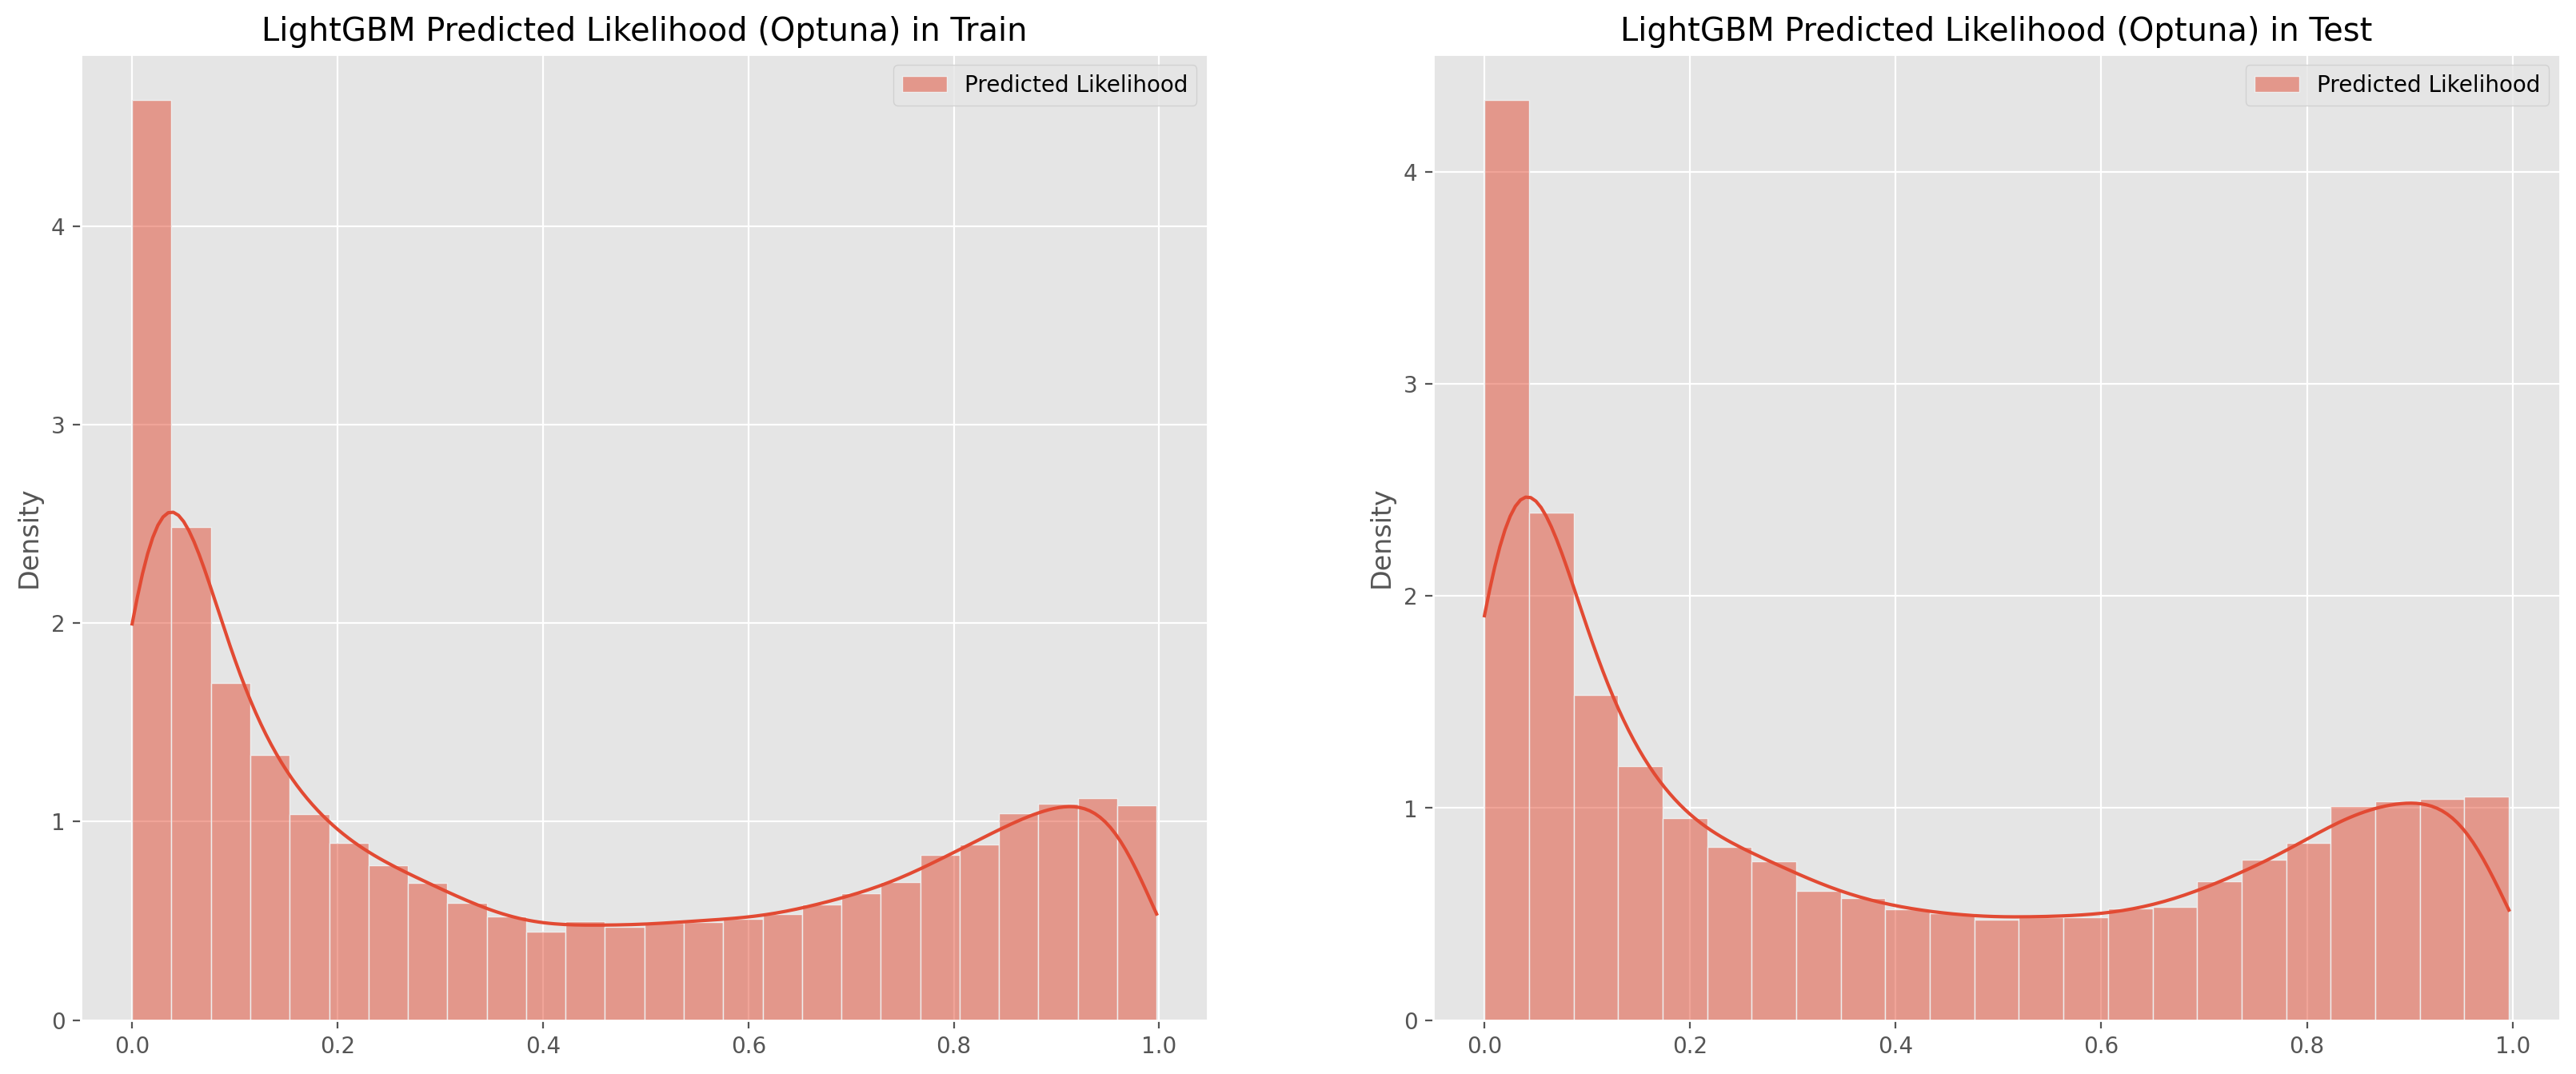

In [30]:
lgb_preds_train = train_preds['booking_status_pred']
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': lgb_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': lgb_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'LightGBM Predicted Likelihood (Optuna) in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'LightGBM Predicted Likelihood (Optuna) in Test')
plt.show();

In [31]:
submission['booking_status'] = lgb_preds_test
submission.head()

,id,booking_status
0,42100,0.091032
1,42101,0.059127
2,42102,0.333628
3,42103,0.029895
4,42104,0.491624


In [32]:
submission.to_csv('Baseline_LightGBM_Optuna_submission.csv', index = False)

# More work coming soon...
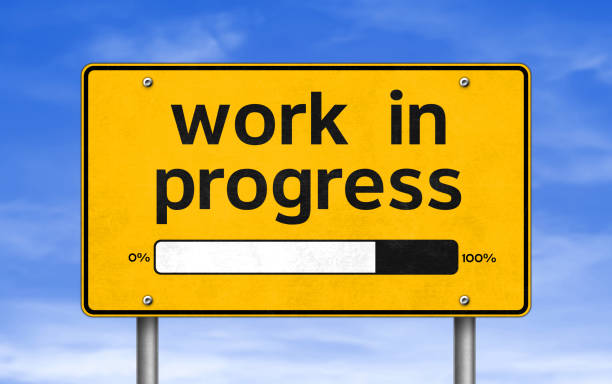